🟦 1. Load data

In [1]:
import pandas as pd
import numpy as np
import os

BASE_DIR = "/kaggle/input/chexpert"

train_df = pd.read_csv(f"{BASE_DIR}/train.csv")
valid_df = pd.read_csv(f"{BASE_DIR}/valid.csv")

train_df.head()


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


🟦 2. Basic dataset summary

In [2]:
print("Train Samples:", len(train_df))
print("Valid Samples:", len(valid_df))
print("\nColumns:", list(train_df.columns))

Train Samples: 223414
Valid Samples: 234

Columns: ['Path', 'Sex', 'Age', 'Frontal/Lateral', 'AP/PA', 'No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']


🟦 3. Define label columns

In [3]:
label_cols = [
    'No Finding','Enlarged Cardiomediastinum','Cardiomegaly','Lung Opacity','Lung Lesion',
    'Edema','Consolidation','Pneumonia','Atelectasis','Pneumothorax','Pleural Effusion',
    'Pleural Other','Fracture','Support Devices'
]


🟦 4. Missing + uncertainty analysis

CheXpert uses:

1 → positive

0 → negative

-1 → uncertainty

We convert uncertainty using the standard rule from CheXpert paper → treat −1 as 1 for EDA.

In [4]:
train_clean = train_df.copy()
train_clean[label_cols] = train_clean[label_cols].fillna(0)
train_clean[label_cols] = train_clean[label_cols].replace(-1, 1)

uncertainty_counts = (train_df[label_cols] == -1).sum()

print("Uncertainty counts:")
print(uncertainty_counts)

Uncertainty counts:
No Finding                        0
Enlarged Cardiomediastinum    12403
Cardiomegaly                   8087
Lung Opacity                   5598
Lung Lesion                    1488
Edema                         12984
Consolidation                 27742
Pneumonia                     18770
Atelectasis                   33739
Pneumothorax                   3145
Pleural Effusion              11628
Pleural Other                  2653
Fracture                        642
Support Devices                1079
dtype: int64


🟦 5. Label frequency distribution

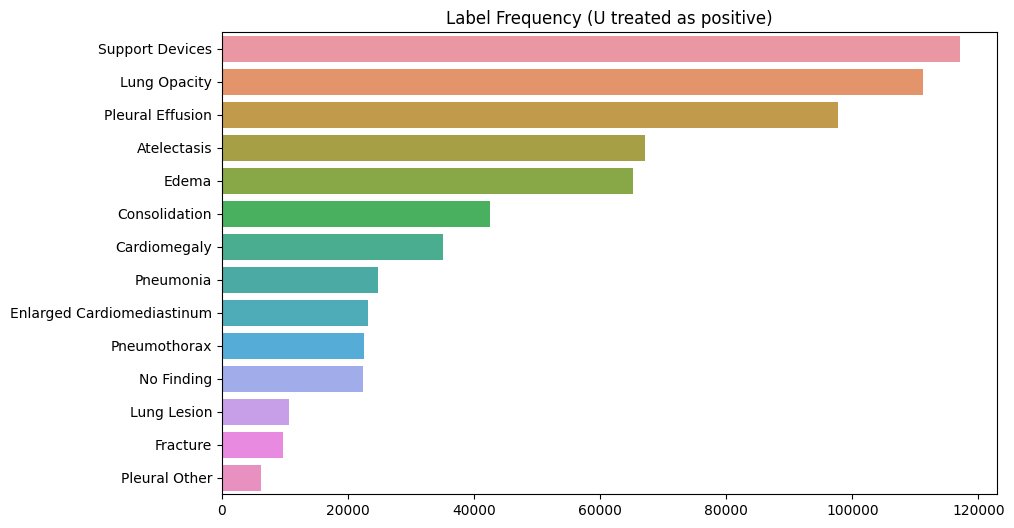

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

label_counts = train_clean[label_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=label_counts.values, y=label_counts.index)
plt.title("Label Frequency (U treated as positive)")
plt.show()


🟦 6. Multi-label count distribution

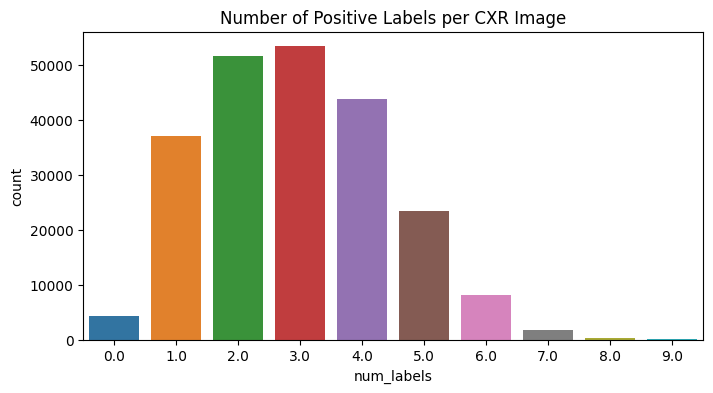

In [6]:
train_clean["num_labels"] = train_clean[label_cols].sum(axis=1)

plt.figure(figsize=(8,4))
sns.countplot(x=train_clean["num_labels"])
plt.title("Number of Positive Labels per CXR Image")
plt.show()

🟦 7. Co-occurrence heatmap

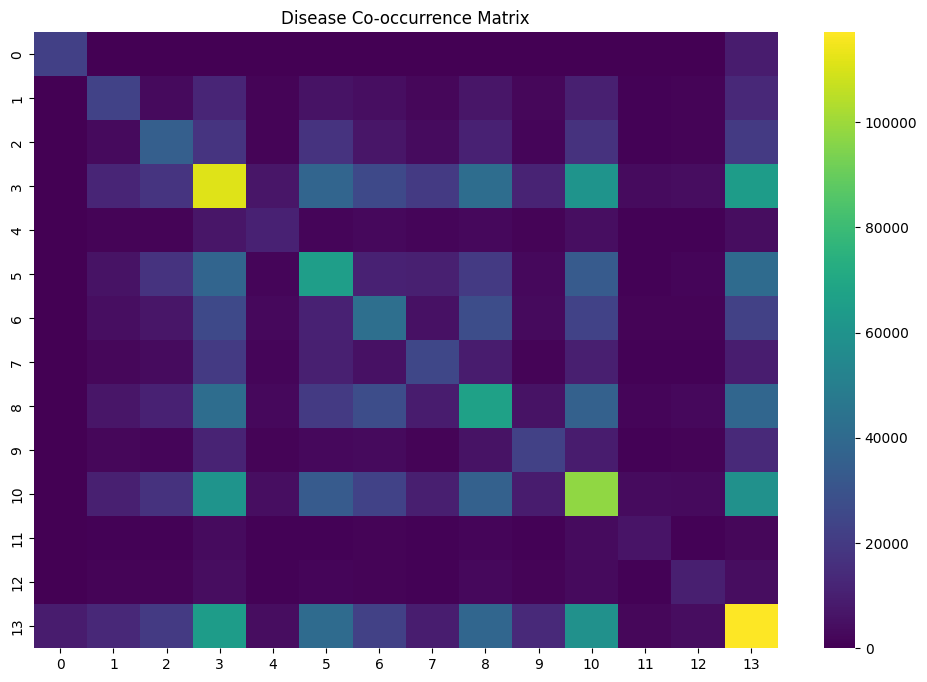

In [7]:
co_matrix = np.dot(train_clean[label_cols].T, train_clean[label_cols])

plt.figure(figsize=(12,8))
sns.heatmap(co_matrix, cmap="viridis")
plt.title("Disease Co-occurrence Matrix")
plt.show()

In [12]:
import os

BASE_DIR = "/kaggle/input/chexpert"

def resolve_path(p: str) -> str:
    # Paths in CSV start with "CheXpert-v1.0-small/..."
    prefix = "CheXpert-v1.0-small/"
    if p.startswith(prefix):
        p = p[len(prefix):]  # drop the prefix
    return os.path.join(BASE_DIR, p)

# sanity check
print("CSV path:", train_df['Path'].iloc[0])
print("Resolved path:", resolve_path(train_df['Path'].iloc[0]))

CSV path: CheXpert-v1.0-small/train/patient00001/study1/view1_frontal.jpg
Resolved path: /kaggle/input/chexpert/train/patient00001/study1/view1_frontal.jpg


🟦 8. Random sample visualization from folders

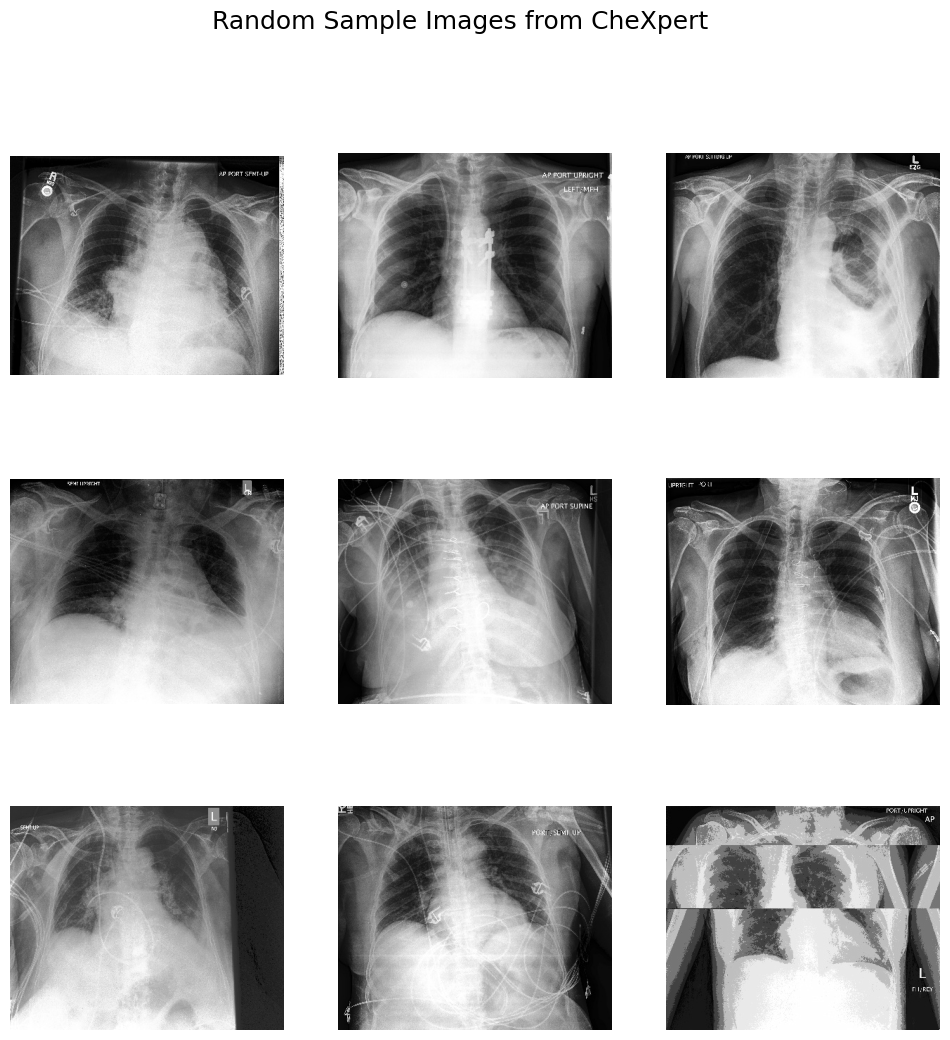

In [13]:
from PIL import Image
import matplotlib.pyplot as plt
import random

sample_paths = train_df['Path'].sample(9).values

plt.figure(figsize=(12,12))
for i, p in enumerate(sample_paths):
    img = Image.open(resolve_path(p))
    plt.subplot(3,3,i+1)
    plt.imshow(img, cmap='gray')
    plt.axis("off")

plt.suptitle("Random Sample Images from CheXpert", fontsize=18)
plt.show()


🟦 9. Image size distribution

In [14]:
sizes = []

for p in train_df['Path'].sample(200):  # sample 200 to save time
    img_path = resolve_path(p)
    img = Image.open(img_path)
    sizes.append(img.size)

sizes = np.array(sizes)
widths = sizes[:,0]
heights = sizes[:,1]

print("Mean size (W, H):", sizes.mean(axis=0))
print("First 10 unique sizes:", np.unique(sizes, axis=0)[:10])


Mean size (W, H): [372.02  327.595]
First 10 unique sizes: [[320 320]
 [320 321]
 [320 324]
 [320 328]
 [320 331]
 [320 347]
 [320 349]
 [320 369]
 [320 371]
 [320 375]]


🟦 10. CLAHE-like enhancement experiment

We use PIL's histogram equalization as CLAHE-like.

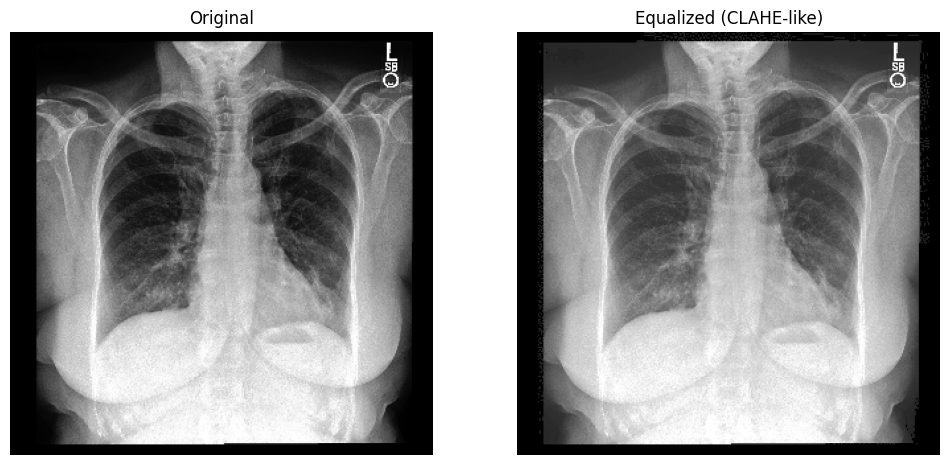

In [15]:
from PIL import ImageOps

path = train_df["Path"].sample(1).values[0]
img = Image.open(resolve_path(path)).convert("L")

eq = ImageOps.equalize(img)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(eq, cmap='gray')
plt.title("Equalized (CLAHE-like)")
plt.axis("off")

plt.show()



🟦 11. Pixel intensity histogram

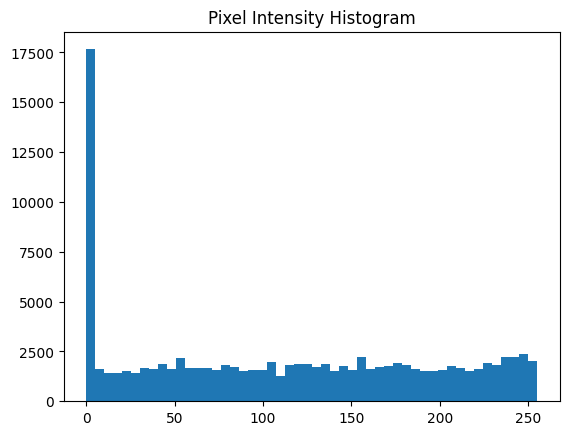

In [16]:
arr = np.array(img)
plt.hist(arr.flatten(), bins=50)
plt.title("Pixel Intensity Histogram")
plt.show()



1️⃣ Capture numeric summaries for the log

a) Label counts (+ prevalence)

In [17]:
label_counts = train_clean[label_cols].sum().sort_values(ascending=False)
label_prevalence = (label_counts / len(train_clean)).round(4) * 100

summary_df = pd.DataFrame({
    "count": label_counts.astype(int),
    "prevalence_%": label_prevalence
})
summary_df

,count,prevalence_%
Support Devices,117080,52.40
Lung Opacity,111179,49.76
Pleural Effusion,97815,43.78
Atelectasis,67115,30.04
Edema,65230,29.20
Consolidation,42525,19.03
Cardiomegaly,35087,15.70
Pneumonia,24809,11.10
Enlarged Cardiomediastinum,23201,10.38
Pneumothorax,22593,10.11


b) Multi-label distribution

In [18]:
multi_dist = train_clean["num_labels"].value_counts().sort_index()
multi_df = multi_dist.to_frame(name="num_images")
multi_df["percent"] = (multi_df["num_images"] / len(train_clean) * 100).round(2)
multi_df

,num_images,percent
num_labels,,
0.0,4256,1.90
1.0,36962,16.54
2.0,51498,23.05
3.0,53351,23.88
4.0,43755,19.58
5.0,23436,10.49
6.0,8082,3.62
7.0,1770,0.79
8.0,282,0.13


c) Uncertainty ratio per label

In [19]:
uncertainty_counts = (train_df[label_cols] == -1).sum()
uncertainty_ratio = (uncertainty_counts / len(train_df) * 100).round(2)

uncert_df = pd.DataFrame({
    "uncertain_count": uncertainty_counts,
    "uncertain_%": uncertainty_ratio
})
uncert_df


,uncertain_count,uncertain_%
No Finding,0,0.00
Enlarged Cardiomediastinum,12403,5.55
Cardiomegaly,8087,3.62
Lung Opacity,5598,2.51
Lung Lesion,1488,0.67
Edema,12984,5.81
Consolidation,27742,12.42
Pneumonia,18770,8.40
Atelectasis,33739,15.10
Pneumothorax,3145,1.41


d) Image size stats

In [20]:
sizes_arr = np.array(sizes)
sizes_df = pd.DataFrame({
    "width": sizes_arr[:,0],
    "height": sizes_arr[:,1]
})
sizes_df.describe()


,width,height
count,200.000000,200.00000
mean,372.020000,327.59500
std,29.795275,21.71309
min,320.000000,320.00000
25%,346.500000,320.00000
50%,390.000000,320.00000
75%,390.000000,320.00000
max,424.000000,471.00000
